# Geography
In the previous tutorial ([Running a query](02-running-a-query.ipynb)), you learned how to run a FlowKit query, and get the result as a pandas dataframe.

In this tutorial you will learn:

- Options for the 'aggregation_unit' parameter  
- How to get a query result as geojson  
- How to get a separate geojson containing the geography (and why you might want to do this)

## Spatial aggregation in FlowKit

- Explain aggregation units, and what the options are (refer to "admin2" in previous tutorial, and explain more)  
- In this tutorial, will learn how to associate query results with geometries of the spatial units to which they are aggregated  

## Getting a query result with geography data

Import flowclient, and also geopandas which we'll use for working with geospatial data.

In [1]:
import flowclient as fc
import geopandas as gpd

Create a connection as before

In [2]:
token = 

conn = fc.connect(
    url="https://api.flowcloud-ghana.flowminder.org",
    token=token,
)

Create a query (same as in previous tutorial)

In [12]:
subscriber_counts_query = fc.unique_subscriber_counts(
    connection=conn,
    start_date="2016-01-01",
    end_date="2016-01-02",
    aggregation_unit="admin2",
)

Get result, this time specify `format="geojson"` to get result as GeoJSON instead of pandas dataframe

In [32]:
subscriber_counts_query_result_geojson = subscriber_counts_query.get_result(format="geojson")

This time, result is a dict

In [33]:
type(subscriber_counts_query_result_geojson)

dict

Load GeoJSON dict into a geopandas GeoDataFrame (equivalent to pandas DataFrame, but contains geometry objects)

In [34]:
subscriber_counts_query_result_geopandas = gpd.GeoDataFrame.from_features(subscriber_counts_query_result_geojson)

Can easily plot the subscriber counts on a choropleth map

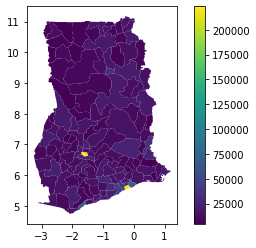

In [35]:
subscriber_counts_query_result_geopandas.plot(column="value", legend=True)

Geopandas allows us to easily save geographic data to a file. For example, to save as shapefile:

In [36]:
subscriber_counts_query_result_geopandas.to_file("admin2_subscriber_counts_20160101.shp")

## Getting geography data separately, and joining to query results

In some cases, you may want to do some further processing of query results before joining to geography. You can get geography data by itself using the `get_geography` method.

As an example, let's calculate average number of events per subscriber in each admin1. Create two new queries, which will count number of events and number of subscribers per admin1 on 1st Feb 2016. (poit out that this time it's admin1, not admin2). Also set both queries running.

In [40]:
event_counts_query = fc.location_event_counts(
    connection=conn,
    start_date="2016-01-01",
    end_date="2016-01-02",
    aggregation_unit="admin1",
    count_interval="day",
)

subscriber_counts_query = fc.unique_subscriber_counts(
    connection=conn,
    start_date="2016-01-01",
    end_date="2016-01-02",
    aggregation_unit="admin1",
)

event_counts_query.run()
subscriber_counts_query.run()

Get the event counts result as a dataframe (as in previous tutorial).

In [41]:
event_counts_query_result_dataframe = event_counts_query.get_result()

In [42]:
event_counts_query_result_dataframe

,pcod,date,value
0,GHA.10_1,2016-01-01,484926
1,GHA.1_1,2016-01-01,1013821
2,GHA.2_1,2016-01-01,437989
3,GHA.3_1,2016-01-01,466017
4,GHA.4_1,2016-01-01,518039
5,GHA.5_1,2016-01-01,792729
6,GHA.6_1,2016-01-01,524167
7,GHA.7_1,2016-01-01,203560
8,GHA.8_1,2016-01-01,125508
9,GHA.9_1,2016-01-01,432808


This one has a 'date' column (but we only ran the query for one date, so it's always 2016-01-01). The 'value' column is the event count - let's rename it to make this clearer

In [44]:
event_counts_query_result_dataframe = event_counts_query_result_dataframe.rename(columns={"value": "event_count"})

 Also get result of subscriber counts query, also as a dataframe (not geojson).

In [43]:
subscriber_counts_query_result_dataframe = subscriber_counts_query.get_result()
subscriber_counts_query_result_dataframe

,pcod,value
0,GHA.10_1,227670
1,GHA.1_1,470364
2,GHA.2_1,204733
3,GHA.3_1,221798
4,GHA.4_1,246271
5,GHA.5_1,372031
6,GHA.6_1,244957
7,GHA.7_1,95686
8,GHA.8_1,59035
9,GHA.9_1,202430


Again, let's rename the 'value' column so it's clear this is the subscriber count

In [45]:
subscriber_counts_query_result_dataframe = subscriber_counts_query_result_dataframe.rename(columns={"value": "subscriber_count"})

Now merge the two result dataframes, joining on 'pcod' (the admin2 region ID)

In [46]:
joined_results = event_counts_query_result_dataframe.merge(subscriber_counts_query_result_dataframe, on="pcod")
joined_results

,pcod,date,event_count,subscriber_count
0,GHA.10_1,2016-01-01,484926,227670
1,GHA.1_1,2016-01-01,1013821,470364
2,GHA.2_1,2016-01-01,437989,204733
3,GHA.3_1,2016-01-01,466017,221798
4,GHA.4_1,2016-01-01,518039,246271
5,GHA.5_1,2016-01-01,792729,372031
6,GHA.6_1,2016-01-01,524167,244957
7,GHA.7_1,2016-01-01,203560,95686
8,GHA.8_1,2016-01-01,125508,59035
9,GHA.9_1,2016-01-01,432808,202430


Average events per subscriber is event count / subscriber count. Add this as a new column

In [48]:
joined_results["events_per_subscriber"] = joined_results["event_count"] / joined_results["subscriber_count"]
joined_results

,pcod,date,event_count,subscriber_count,events_per_subscriber
0,GHA.10_1,2016-01-01,484926,227670,2.129951
1,GHA.1_1,2016-01-01,1013821,470364,2.155397
2,GHA.2_1,2016-01-01,437989,204733,2.139318
3,GHA.3_1,2016-01-01,466017,221798,2.101087
4,GHA.4_1,2016-01-01,518039,246271,2.103532
5,GHA.5_1,2016-01-01,792729,372031,2.130814
6,GHA.6_1,2016-01-01,524167,244957,2.139833
7,GHA.7_1,2016-01-01,203560,95686,2.127375
8,GHA.8_1,2016-01-01,125508,59035,2.125993
9,GHA.9_1,2016-01-01,432808,202430,2.138063


Now we can use `get_geography` to get the admin1 boundaries as geojson (explain parameters), and then load this into a geopandas geodataframe as we did before

In [49]:
admin1_geojson = fc.get_geography(connection=conn, aggregation_unit="admin1")
admin1_geopandas = gpd.GeoDataFrame.from_features(admin1_geojson)
admin1_geopandas

,geometry,pcod,centroid
0,"MULTIPOLYGON (((-1.54145 5.93492, -1.55517 5.9...",GHA.1_1,"{'type': 'Point', 'coordinates': [-1.448572511..."
1,"MULTIPOLYGON (((-1.32043 7.59765, -1.33175 7.6...",GHA.2_1,"{'type': 'Point', 'coordinates': [-1.657978191..."
2,"MULTIPOLYGON (((-0.65097 5.32708, -0.65208 5.3...",GHA.3_1,"{'type': 'Point', 'coordinates': [-1.197225787..."
3,"MULTIPOLYGON (((-0.15026 5.76965, -0.16500 5.7...",GHA.4_1,"{'type': 'Point', 'coordinates': [-0.450589257..."
4,"MULTIPOLYGON (((0.68486 5.78069, 0.68486 5.780...",GHA.5_1,"{'type': 'Point', 'coordinates': [0.065873422,..."
5,"MULTIPOLYGON (((-1.93358 8.20847, -1.94060 8.1...",GHA.6_1,"{'type': 'Point', 'coordinates': [-0.966658207..."
6,"MULTIPOLYGON (((-1.49338 10.44206, -1.49013 10...",GHA.7_1,"{'type': 'Point', 'coordinates': [-0.820530825..."
7,"MULTIPOLYGON (((-2.79029 10.12870, -2.79017 10...",GHA.8_1,"{'type': 'Point', 'coordinates': [-2.209539873..."
8,"MULTIPOLYGON (((0.90236 5.91292, 0.90236 5.912...",GHA.9_1,"{'type': 'Point', 'coordinates': [0.392035024,..."
9,"MULTIPOLYGON (((-2.03542 4.75180, -2.03542 4.7...",GHA.10_1,"{'type': 'Point', 'coordinates': [-2.415957617..."


Plot the admin1 polygons

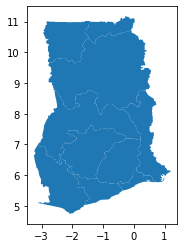

In [50]:
admin1_geopandas.plot()

Join the admin1 boundaries to our 'joined_results' dataframe, using the 'pcod' region ID column (note: join geo to results, not other way around, so that result is a GeoDataFrame rather than just a DataFrame)

In [51]:
joined_results_with_geography = admin1_geopandas.merge(joined_results, on="pcod")

Can now plot the events per subscriber on a choropleth map

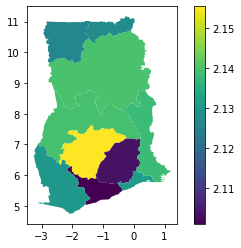

In [52]:
joined_results_with_geography.plot(column="events_per_subscriber", legend=True)

## Summary

In this tutorial you learned:

- how to aggregate results to a particular set of spatial regions, and what "aggregation units" are available  
- how to get query result with geography data (using `get_result(format="geojson")`)  
- how to load geojson into a geopandas GeoDataFrame, and use geopandas to plot / save the data  
- how to get geography data separately (using `get_geography`), and join this to data in a pandas DataFrame  

Next, try out the COVID how-to (coming soon...)